# Forest elephant rumble vocalisation analysis

This Jupyter notebook provides a step-by-step guide to using unsupervised deep learning techniques (UDL) to identify rumble vocalisation sub-types and to identify associations between rumble acoustic features and different contexts (age, sex, behaviour, distress). This builds on the call-types analysis notebook using the main UDL techniques of transfer learning to automatically extract acoustic features and unsupervised ordination of these features into lower dimensional space. 

## Dataset Description

The call-type dataset contains audio files of African forest elephants rumble vocalisations recorded by the Elephant Listening Project in the Dzanga-Bai clearing in the the southwestern Central African Republic between September 2018 and April 2019. It has 361 rows each representing an elephant rumble with the start time, end time, low frequency and high frequency annotated alongside different categorical labels pertaining to the age, sex, behavioural context and distress of the vocaliser.

## Steps

1. **Set-up** Import the libraries and functions needed to conduct the analysis, load the dataset and understand its structure
2. **Audio pre-processing and feature extraction**: Pre-process the data to isolate the vocalisations and automatically extract the acoustic features using a pre-trained Convolutional Neural Network.
3. **Dimensionality reduction**: Project the acoustic features into 1D space as the basis for clustering and statistical analysis
4. **Unsupervised clustering**: Cluster the UMAP ordination of the acoustic features to identify sub-groups and the most prominent categorical labels in each cluster. This corresponds to research question 2 in the paper.
5. **Behavioural and demographic analysis**: Perform statistical tests to assess the signficance of changes in acoustic features and different contexts. This corresponds to research question 3 in the paper.

### 1. Set-up

Here we will import a series of pre-defined scripts used to automate the import of the libraries needed for each of the aforementioned steps. These are all located in the "elephant_scripts" folder in the main project repository.

In [39]:
# Step 1: load all of the main libraries needed for the notebook set-up
%run elephant_scripts/import_libraries_behaviour
%run elephant_scripts/load_data_behaviour

# Step 2: load the functions needed for audio pre-processing and feature extraction
%run elephant_scripts/feature_extraction

# Step 3 & 4: load the functions needed for dimensionality reduction and clustering
%run elephant_scripts/umap_projections_behaviour

# Step 5: load the functions to calculate and visualise the statistical relationship between rumbles and behavioural contexts
%run elephant_scripts/behaviour_stats

# enable plots to be auto-displayed in the notebook
%matplotlib inline 

df

Main libraries successfully imported
Info file loaded: /home/alastair/forestdata/alastair/temp/elephant_analysis_repository/data/2.elephant_rumble_behaviour_df.csv
Audio file paths added to DataFrame
Vocalisation Dataset successfully loaded


<Figure size 640x480 with 0 Axes>

Functions for Audio Pre-processing and Feature Extraction successfully loaded
Functions for Dimensionality Reduction successfully loaded
Functions for Statistical Analysis successfully loaded


,filename,start_time,end_time,duration,low_freq,high_freq,call-type,Final_Category,Distress,Age,Sex,Age_Sex,audio_filepaths
0,opp_578_ru.wav,2.392645,6.613464,4.220819,0.219727,1417.993164,rumble,Nursing,Not Applicable,Juvenile,Male,Juvenile Male,/home/alastair/forestdata/alastair/temp/elepha...
1,opp_595_ru.wav,1.807122,10.038406,8.231284,1.025391,1397.607422,rumble,Logistics,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
2,opp_560_ru.wav,2.299110,6.934491,4.635381,1.147461,546.850586,rumble,Separation,No distress,Sub-Adult,Male,Sub-Adult Male,/home/alastair/forestdata/alastair/temp/elepha...
3,opp_420_ru.wav,1.832432,6.438646,4.606213,0.708008,486.108398,rumble,Sexual,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
4,opp_582_ru5.wav,0.982550,5.686105,4.703555,1.391602,481.103516,rumble,Affiliation,Not Applicable,Sub-Adult,Female,Sub-Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,opp_346_ru.wav,0.794323,6.482651,5.688328,0.585938,168.164062,rumble,Separation,Distress,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
357,opp_669_ru1.wav,2.830313,4.420829,1.590516,0.048828,163.940430,rumble,Logistics,Not Applicable,Sub-Adult,Female,Sub-Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
358,opp_755_ru2.wav,1.031033,1.726944,0.695912,23.608398,140.112305,rumble,Competition,Unknown,Juvenile,Male,Juvenile Male,/home/alastair/forestdata/alastair/temp/elepha...
359,opp_495_ru.wav,1.136562,3.769334,2.632772,2.612305,136.523438,rumble,Competition,Unknown,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...


### 2. Audio pre-processing and feature extraction

Now that the dataframe is loaded and associated with the audio files, we need to pre-process the audio files to extract the exact frequency ranges and time periods associated with the vocalisations. This helps to minimise unwanted environmental sound that may cause erroneous results. These are the steps take to pre-process the files and extract their audio features:

<ol type="A">

<li>Read the entire audio file.<li>
Apply a bandpass filter to exclude frequencies outside the vocalisation range using the low_frequency and high_frequency information.<li>
Extract the audio clip corresponding to the vocalisation using the start_time and end_time information.<li>
Zero-pad the vocalisation to a length that is a multiple of 96 (the input size of the VGGish model) and centre the recording within this padding.<li>
Normalise the audio clip to have a peak amplitude of 1 to control for elephant distance from the microphone.<li>
Reapply the bandpass filter to remove any acoustic artifacts that have been introduced by the pre-processing.

These individual steps are combined in one single function called the wav_cookiecutter which we'll use for the pre-processing the rest of the data

The pre-processed audio files are then passed through the VGGish pre-trained CNN in 0.96s multiples and their acoustic features are automatically extracted to produce embeddings. These embeddings are then averaged to obtain a single embedding per vocalisation. This feature extraction phase involves the following steps:

1. Extract the acoustic feature embeddings for each 96-sample chunk of the audio clip using the pretrained CNN VGGish.
2. Average the embeddings across the chunks to obtain a single embedding for each vocalisation.
3. Add in information about the duration of each vocalisation

This resulting embedding encodes the acoustic feature representation of the vocalisation.

In [40]:
# Set audio parameters used in the functions below
samplerate = DEFAULT_SAMPLERATE
window_size = DEFAULT_WINDOW_SIZE
position = DEFAULT_CLIP_POSITION

model = hub.load('https://tfhub.dev/google/vggish/1')

# Extract VGGish features
results = []
for _, annotation in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    # Apply the wav_cookiecutter function combining all of the audio
    # pre-processing steps
    wav = wav_cookiecutter(
        annotation,
        window_size=window_size,
        position="middle",
        samplerate=samplerate,
    )

    embeddings = model(wav)
    assert embeddings.shape[1] == 128  # Check the number of features per frame

    # Store info of the embeddings of each frame
    for embedding in embeddings:
        results.append(
            {
                "filename": annotation.filename,
                **{f"feature_{n}": feat for n, feat in enumerate(embedding)},
            }
        )
results = pd.DataFrame(results)

# average vggish annotation feature vectors back into original # of annotations
results = results.groupby("filename").mean()

# Add in the missing duration information as the 129th feature
duration = df[["filename", "duration"]].copy()
results = results.join(duration.set_index("filename"))

results

Processing: 100%|██████████| 361/361 [00:22<00:00, 15.76it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,duration
filename,,,,,,,,,,,,,,,,,,,,,
opp_330_ru.wav,-0.246848,-0.111789,0.241722,-0.195451,0.101328,-0.366939,-0.180415,0.016249,-0.349659,-0.147815,...,0.047084,-0.12486,-0.135784,0.080366,0.291493,-0.100012,-0.192962,0.228055,-0.119971,2.161813
opp_332_ru.wav,-0.14961,0.129676,0.085841,-0.098854,0.040766,-0.487508,-0.158237,0.22541,-0.535318,0.109821,...,0.107642,-0.155294,0.056881,-0.230121,-0.001885,-0.100687,-0.297468,-0.061319,0.094915,3.522186
opp_333_ru.wav,-0.161457,0.042482,0.090267,-0.00557,-0.023373,-0.54754,-0.165326,0.148796,-0.87906,-0.020349,...,-0.049731,-0.290999,0.053796,-0.348644,0.07725,-0.015267,-0.368231,-0.094716,0.16168,3.540844
opp_333_ru1.wav,-0.113422,0.033881,0.179464,-0.152382,0.039331,-0.561756,-0.092054,0.174603,-1.016679,-0.091761,...,0.036599,-0.223549,0.051192,-0.232041,0.077678,0.030441,-0.270696,-0.020462,0.183512,3.441889
opp_333_ru2.wav,-0.242428,-0.14745,0.098017,-0.081086,0.001065,-0.622324,-0.058791,0.168942,-1.242459,-0.102003,...,-0.080686,-0.400064,0.02553,-0.511895,-0.01331,-0.027813,-0.63056,-0.074626,0.185636,3.261884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_876_ru2.wav,-0.024894,0.045767,0.110447,-0.072183,0.243159,-0.255672,-0.051282,0.203329,-0.238551,0.004844,...,0.044813,-0.191217,0.16405,-0.196267,0.083124,-0.06605,-0.152629,-0.011545,0.017836,2.381324
opp_876_ru3.wav,-0.392591,-0.193636,0.31771,-0.121416,0.190764,-0.330069,-0.027058,0.165353,-0.229536,-0.33113,...,-0.068928,-0.083521,-0.026139,-0.214735,-0.040516,-0.14961,-0.49971,0.198395,-0.227462,1.188828
opp_878_ru.wav,-0.382297,0.227646,0.053632,0.005211,-0.104698,-0.381395,-0.078889,0.193316,-0.23203,-0.115835,...,0.137279,-0.134785,0.086429,-0.174174,-0.077103,-0.120511,-0.409068,-0.004873,0.045533,4.546284


In [41]:
# Save the extracted acoustic features to a csv file
results.to_csv(os.path.join(os.path.sep, DATA, 'rumble_acoustic_features.csv'))

### 3. Dimensionality reduction

Now that we have the 129D embeddings for each of the 361 recordings we need to reduce this high-dimensional data into lower dimensional space to make it interpretable to the human brain and usable in the statistical tests. This involves 4 steps:
1. Specify the parameters for the dimensionality reduction, including the number of components (1) and distance metric we want to use (cosine)
2. Normalise the 129D embeddings so that their mean = 0 and variance = 1. This ensures equal weighting of the features
3. Carry out the dimensionality reduction

In [43]:
# Load the saved acoustic features
results = pd.read_csv(os.path.join(os.path.sep, DATA, 'rumble_acoustic_features.csv'))
results = results.set_index('filename')

# Specify the UMAP parameters
results_df = results # name of the dataframe where the embeddings are contained
metadata_df = df # name of the dataframe where the call-type labels are contained
N_COMP = 1 # select number of dimensions
metric = 'cosine' 
min_dist = 0
random_state = 2204
n_neighbors = 14
damping = 0.95
preference=-50
max_iter=1000

In [44]:
scaler = StandardScaler()
normalised = scaler.fit(results_df)
normalised_df = pd.DataFrame(scaler.transform(results_df), columns = results_df.columns, index = results_df.index)
normalised_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,duration
filename,,,,,,,,,,,,,,,,,,,,,
opp_330_ru.wav,0.367740,-0.223345,0.832650,-0.150125,1.173903,0.017512,-0.658524,0.080850,0.016878,0.084146,...,-0.760345,-0.752949,-0.552275,0.989991,1.264996,0.102087,0.633005,0.931091,-0.583415,-0.615028
opp_332_ru.wav,0.909980,1.053873,-0.661153,0.305009,0.626951,-0.664588,-0.524754,1.411508,-0.707733,1.634552,...,-0.255880,-1.012490,1.133998,-1.171262,-0.609187,0.097003,0.067107,-1.002129,0.921309,0.163114
opp_333_ru.wav,0.843913,0.592664,-0.618734,0.744534,0.047700,-1.004212,-0.567517,0.924098,-2.049332,0.851215,...,-1.566839,-2.169782,1.106990,-1.996287,-0.103649,0.739693,-0.316070,-1.225245,1.388820,0.173786
opp_333_ru1.wav,1.111779,0.547173,0.236033,0.052802,0.613999,-1.084641,-0.125571,1.088283,-2.586449,0.421471,...,-0.847688,-1.594563,1.084204,-1.184629,-0.100915,1.083589,0.212078,-0.729177,1.541697,0.117184
opp_333_ru2.wav,0.392385,-0.411974,-0.544465,0.388729,0.268408,-1.427294,0.075050,1.052266,-3.467648,0.359834,...,-1.824702,-3.099885,0.859605,-3.132650,-0.682167,0.645300,-1.736565,-1.091032,1.556570,0.014220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_876_ru2.wav,1.605449,0.610043,-0.425349,0.430673,2.454805,0.646995,0.120340,1.271033,0.450523,1.002822,...,-0.779263,-1.318837,2.071971,-0.935612,-0.066124,0.357612,0.851405,-0.669603,0.381563,-0.489466
opp_876_ru3.wav,-0.444989,-0.656271,1.560830,0.198704,1.981614,0.226100,0.266449,1.029434,0.485706,-1.019013,...,-1.726758,-0.400408,0.407377,-1.064165,-0.855973,-0.271081,-1.028018,0.732939,-1.336113,-1.171581
opp_878_ru.wav,-0.387583,1.572086,-0.969803,0.795332,-0.686758,-0.064268,-0.046166,1.207333,0.475972,0.276595,...,-0.008997,-0.837589,1.392606,-0.781824,-1.089698,-0.052146,-0.537201,-0.625027,0.575515,0.748905


In [45]:
# Function to fit UMAP and return the embedding

def fit_umap(transformed_df, N_COMP, metric, min_dist, n_neighbors, random_state):
    reducer = umap.UMAP(n_components=N_COMP, metric=metric, min_dist=min_dist, n_neighbors = n_neighbors, random_state=random_state)
    return reducer.fit_transform(transformed_df)

# Fit UMAP and obtain embeddings
embeddings = fit_umap(normalised_df, N_COMP, metric, min_dist, n_neighbors, random_state)
embeddings

array([[ 1.0288175],
       [14.946022 ],
       [15.191775 ],
       [15.021379 ],
       [17.173191 ],
       [ 3.1475248],
       [18.79924  ],
       [11.420613 ],
       [17.78729  ],
       [16.249632 ],
       [ 3.4709253],
       [ 6.964533 ],
       [ 1.6078218],
       [13.129976 ],
       [ 2.7225595],
       [ 2.3866155],
       [17.483595 ],
       [ 1.1246002],
       [ 9.020732 ],
       [18.564669 ],
       [ 3.8435721],
       [ 2.0074365],
       [ 3.8003943],
       [ 6.3379855],
       [13.537108 ],
       [17.345644 ],
       [14.614272 ],
       [ 3.2351794],
       [15.976224 ],
       [ 4.885398 ],
       [ 5.134397 ],
       [ 3.33689  ],
       [ 1.1537197],
       [ 1.9993926],
       [14.41291  ],
       [ 8.844041 ],
       [ 4.506319 ],
       [13.765831 ],
       [13.279771 ],
       [16.39357  ],
       [ 3.4386396],
       [ 9.045164 ],
       [12.832753 ],
       [ 4.5001917],
       [ 3.6883044],
       [ 4.592966 ],
       [ 7.444811 ],
       [11.67

### 4. Unsupervised Clustering: Rumble Sub-type identification

In [46]:
def affinity_propagation_clustering(features_standardized, damping=0.5, preference= None, random_state = None):
    # Perform affinity propagation clustering
    affinity_propagation = AffinityPropagation(damping=damping, preference=preference, random_state = random_state)
    cluster_labels = affinity_propagation.fit_predict(embeddings)
    return cluster_labels

# Perform affinity propagation clustering 
cluster_labels = None
cluster_labels = affinity_propagation_clustering(embeddings, damping=damping, preference=preference, random_state=random_state)
cluster_labels

array([4, 1, 1, 1, 0, 3, 5, 7, 5, 0, 3, 2, 4, 7, 4, 4, 5, 4, 6, 5, 3, 4,
       3, 2, 1, 5, 1, 3, 0, 3, 3, 3, 4, 4, 1, 6, 3, 1, 1, 0, 3, 6, 7, 3,
       3, 3, 2, 7, 4, 5, 1, 1, 7, 2, 1, 3, 0, 2, 0, 4, 1, 4, 6, 1, 5, 2,
       6, 6, 0, 7, 3, 1, 5, 2, 3, 7, 0, 0, 3, 7, 7, 0, 3, 3, 1, 3, 4, 0,
       5, 3, 5, 1, 1, 4, 4, 5, 3, 3, 2, 1, 5, 4, 4, 7, 2, 0, 2, 2, 2, 1,
       6, 6, 3, 0, 3, 2, 6, 6, 1, 6, 7, 1, 7, 6, 2, 5, 0, 5, 6, 4, 2, 0,
       0, 2, 2, 2, 6, 3, 3, 1, 3, 0, 6, 1, 6, 1, 1, 0, 0, 1, 2, 5, 6, 5,
       1, 0, 3, 4, 2, 0, 2, 0, 2, 2, 4, 1, 4, 2, 4, 4, 3, 1, 7, 1, 3, 3,
       4, 4, 2, 4, 3, 0, 4, 5, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 5,
       0, 5, 5, 4, 0, 0, 1, 0, 4, 0, 4, 4, 1, 0, 4, 7, 7, 4, 4, 4, 6, 4,
       1, 4, 7, 4, 5, 2, 2, 4, 1, 6, 4, 4, 4, 3, 4, 4, 7, 5, 5, 0, 5, 5,
       3, 4, 2, 6, 6, 5, 3, 2, 2, 2, 4, 4, 4, 7, 1, 3, 4, 1, 5, 4, 4, 0,
       6, 2, 3, 0, 4, 2, 7, 5, 5, 0, 1, 1, 5, 1, 0, 3, 7, 4, 1, 5, 5, 3,
       0, 5, 5, 5, 5, 6, 7, 6, 3, 4, 2, 5, 5, 0, 7,

In [47]:
# Create a DataFrame with UMAP coordinates and add the 'Cluster' column
umap_cluster_results = pd.DataFrame(
    {
        "filename": normalised_df.index,
        **{f"UMAP{i + 1}": embeddings[:, i] for i in range(N_COMP)},
        "Cluster": cluster_labels  # Add the 'Cluster' column
    }
)

# Set 'filename' as the index
umap_cluster_results = umap_cluster_results.set_index("filename")
umap_cluster_results

,UMAP1,Cluster
filename,,
opp_330_ru.wav,1.028818,4
opp_332_ru.wav,14.946022,1
opp_333_ru.wav,15.191775,1
opp_333_ru1.wav,15.021379,1
opp_333_ru2.wav,17.173191,0
...,...,...
opp_876_ru2.wav,14.218194,1
opp_876_ru3.wav,13.152391,7
opp_878_ru.wav,19.041962,5


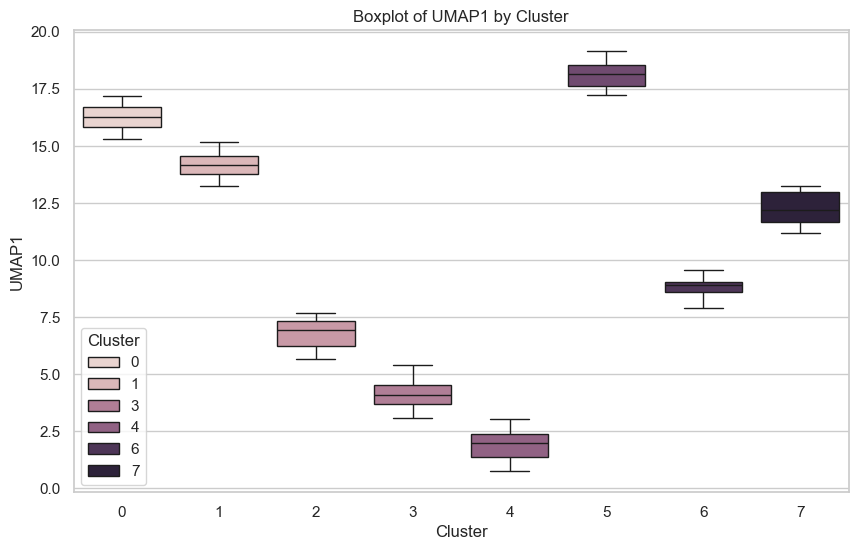

In [48]:
# Set the style of the visualisation
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='UMAP1', data=umap_cluster_results, hue = 'Cluster')

# Set the title and labels
plt.title('Boxplot of UMAP1 by Cluster')
plt.xlabel('Cluster')
plt.ylabel('UMAP1')

# Show the plot
plt.show()

In [49]:
cluster_df = pd.merge(umap_cluster_results, metadata_df, how='left', left_index=True, right_on='filename')
cluster_df = cluster_df.set_index("filename")
cluster_df

,UMAP1,Cluster,start_time,end_time,duration,low_freq,high_freq,call-type,Final_Category,Distress,Age,Sex,Age_Sex,audio_filepaths
filename,,,,,,,,,,,,,,
opp_330_ru.wav,1.028818,4,1.628424,3.790237,2.161813,1.220703,326.464844,rumble,Nursing,Not Applicable,Juvenile,Unknown,Unknown,/home/alastair/forestdata/alastair/temp/elepha...
opp_332_ru.wav,14.946022,1,2.229882,5.752067,3.522186,1.635742,197.631836,rumble,Logistics,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
opp_333_ru.wav,15.191775,1,3.098901,6.639745,3.540844,0.756836,197.167969,rumble,Unknown,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
opp_333_ru1.wav,15.021379,1,1.130586,4.572474,3.441889,0.048828,299.731445,rumble,Unknown,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
opp_333_ru2.wav,17.173191,0,2.029501,5.291385,3.261884,1.196289,324.829102,rumble,Unknown,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_876_ru2.wav,14.218194,1,1.628046,4.009370,2.381324,0.463867,287.939453,rumble,Separation,Distress,Juvenile,Male,Juvenile Male,/home/alastair/forestdata/alastair/temp/elepha...
opp_876_ru3.wav,13.152391,7,2.145454,3.334282,1.188828,10.253906,343.530273,rumble,Separation,Distress,Juvenile,Male,Juvenile Male,/home/alastair/forestdata/alastair/temp/elepha...
opp_878_ru.wav,19.041962,5,3.575788,8.122073,4.546284,1.391602,244.506836,rumble,Affiliation,Not Applicable,Adult,Female,Adult Female,/home/alastair/forestdata/alastair/temp/elepha...


We can visually assess the level of separation achieved by the unsupervised methods but this needs to be accompanied by a statistical analysis of its performance. We will do this by calculating the overall silhouette score for the data and the silhouette score per call-type.

The silhouete score is a mathematical representation of the tightness and separation of each cluster (Rousseeuw, 1987). It is calculated as the mean Euclidean distance between data points within a cluster (a) and the mean Euclidean distance to points in the nearest cluster (Rousseeuw, 1987).

Typically, silhouette scores >=0.5 show evidence for clustering, while those >=0.7 show strong evidence for clustering.

In [50]:
# Define data and embeddings
embeddings = cluster_df[['UMAP1']].values
labels = cluster_df['Cluster'].values

# Calculate silhouette scores
silhouette_avg = silhouette_score(embeddings, labels)
print("Average Silhouette Score:", silhouette_avg)

# Calculate silhouette scores per sample
sample_silhouette_values = silhouette_samples(embeddings, labels)

# Add silhouette scores to 'cluster_df'
cluster_df['Cluster_Silhouette_Score'] = sample_silhouette_values

# Calculate count per cluster
cluster_counts = cluster_df['Cluster'].value_counts()

# Create a list to store silhouette scores and counts per cluster
cluster_results = []

# Iterate over each unique cluster label
unique_clusters = cluster_df['Cluster'].unique()
for cluster_label in unique_clusters:
    # Filter samples belonging to the current cluster
    cluster_mask = cluster_df['Cluster'] == cluster_label
    cluster_count = cluster_counts[cluster_label]
    
    # Retrieve silhouette scores for samples in the current cluster
    cluster_silhouette_values = sample_silhouette_values[cluster_mask]
    
    # Calculate average silhouette score for the current cluster
    cluster_silhouette_avg = cluster_silhouette_values.mean()
    
    # Store cluster label, silhouette score, and count in the list
    cluster_results.append({
        'Cluster': cluster_label, 
        'Silhouette_Score': cluster_silhouette_avg, 
        'Count': cluster_count
    })

# Convert list to DataFrame
cluster_results_df = pd.DataFrame(cluster_results)
cluster_results_df


Average Silhouette Score: 0.585316


,Cluster,Silhouette_Score,Count
0,4,0.627086,59
1,1,0.547502,47
2,0,0.535080,44
3,3,0.573070,61
4,5,0.595831,49
5,7,0.498397,29
6,2,0.581006,44
7,6,0.744789,28


Plot column charts of the unsupervised clusters split by their Age, Sex, Distress and Behaviour labels to identify patterns in the cluster composition

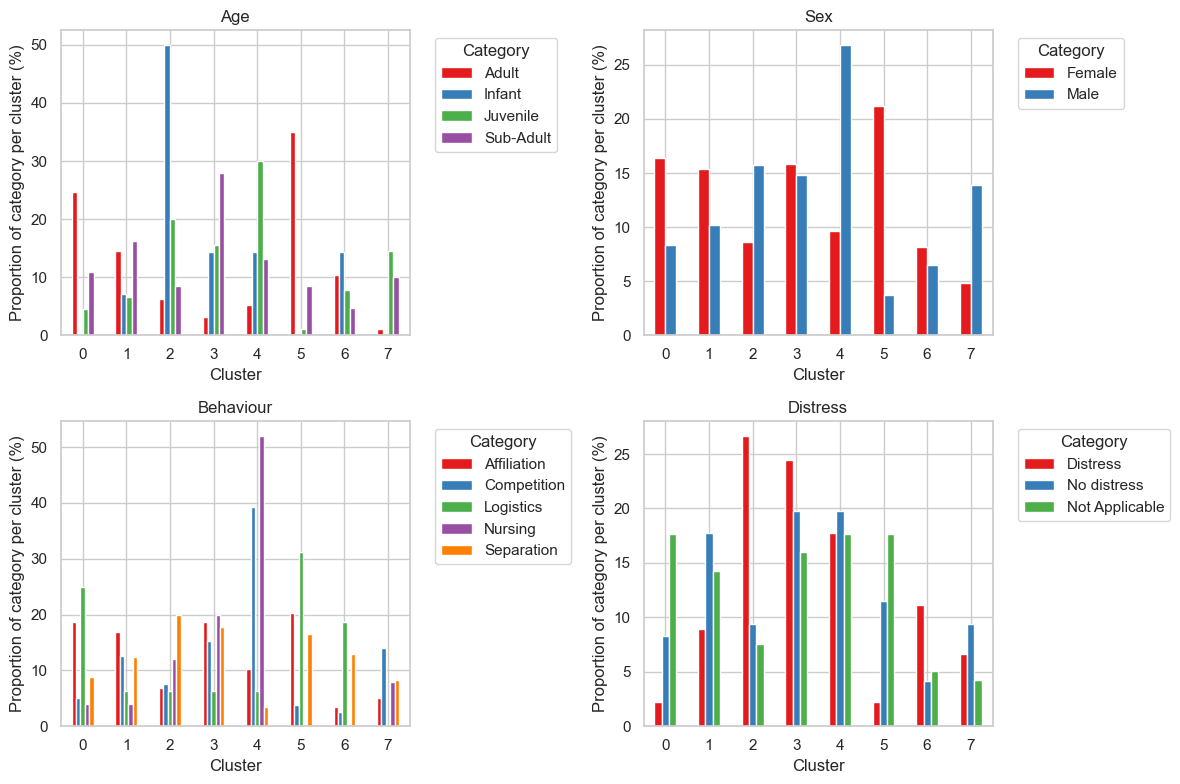

In [51]:
# Set the seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Set1")

# Set up the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define the variables to be plotted
variables = ['Age', 'Sex', 'Final_Category', 'Distress']

# Define custom titles for each graph
titles = ['Age', 'Sex', 'Behaviour', 'Distress']

# Iterate over each variable and plot a bar chart in the corresponding subplot
for i, (variable, title) in enumerate(zip(variables, titles)):
    df_filtered = cluster_df.copy()  # Make a copy of the DataFrame
    
    # Exclude 'Unknown' values for the 'Distress' variable
    if variable == 'Distress':
        df_filtered = df_filtered[df_filtered[variable] != 'Unknown']
    
    # Exclude 'Anti-Predator' and 'Sexual' levels for the 'Final_Category' variable
    if variable == 'Final_Category':
        df_filtered = df_filtered[(df_filtered[variable] != 'Anti-Predator') & (df_filtered[variable] != 'Sexual') & (df_filtered[variable] != 'Unknown')]
    
    # Exclude 'Unknown' values for other variables
    if variable in ['Age', 'Sex']:
        df_filtered = df_filtered[df_filtered[variable] != 'Unknown']
    
    # Calculate counts for each category in the variable, grouped by Cluster
    counts = df_filtered.groupby(['Cluster', variable]).size().unstack().fillna(0)
    
    # Calculate proportions
    proportions = counts.div(counts.sum(axis=0), axis=1) * 100
    
    # Plot the bar chart in the i-th subplot
    ax = proportions.plot(kind='bar', stacked=False, ax=axes[i//2, i%2])
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Proportion of category per cluster (%)')
    
    # Remove 'Unknown' and 'Anti-Predator' from the legend
    handles, labels = ax.get_legend_handles_labels()
    filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l not in ['Unknown', 'Anti-Predator', 'Sexual']]
    if filtered_handles_labels:
        handles, labels = zip(*filtered_handles_labels)
        ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Category")
    else:
        ax.legend().remove()
    
    # Rotate cluster labels to be horizontal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


## 5. Behavioural and Demographic Analysis

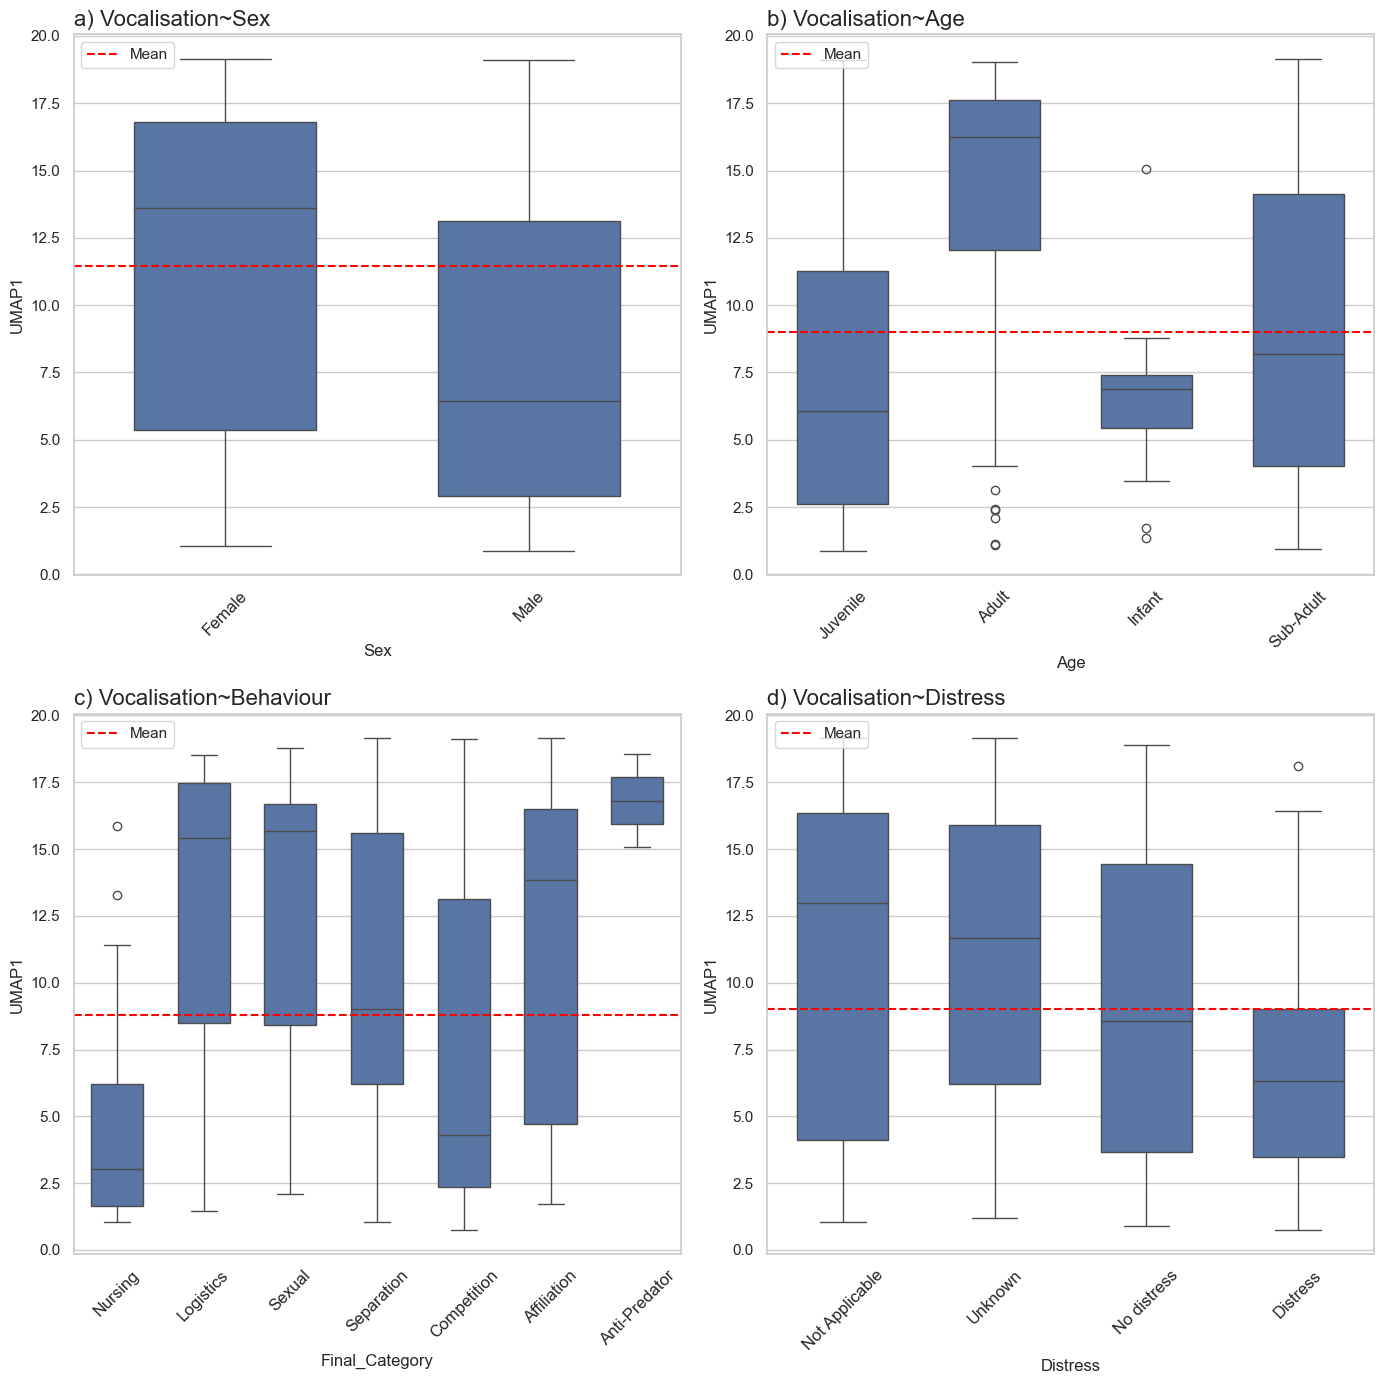

In [52]:
# Visualise the associations between the variables using boxplots
create_boxplots(cluster_df)

In [53]:
# Create new dataframe, remove unknowns and convert categorical variables to category type
filtered_df = cluster_df.copy()
filtered_df = filtered_df[(filtered_df['Final_Category'] != 'Unknown') & (filtered_df['Age'] != 'Unknown') &(filtered_df['Sex']!= 'Unknown')]
cat_vars = ['Age', 'Sex', 'Final_Category', 'Distress']
filtered_df[cat_vars] = filtered_df[cat_vars].astype('category')

Specify and run GLM to test statistical significance of the variables

In [54]:
def fit_glm_model(df):
    # Specify the formula 
    formula = 'UMAP1 ~ C(Final_Category,Treatment("Separation")) + C(Distress,Treatment("No distress")) +C(Age) +C(Sex)'

    # Specify the family and link for the GLM
    glm_model = sm.GLM.from_formula(formula, family=sm.families.Gaussian(), data=filtered_df)
    glm_model_result = glm_model.fit()

    # Print the summary of the model
    print(glm_model_result.summary())

    return glm_model_result

behaviour_context_model = fit_glm_model(filtered_df)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  UMAP1   No. Observations:                  284
Model:                            GLM   Df Residuals:                      271
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                          24.771
Method:                          IRLS   Log-Likelihood:                -852.10
Date:                Mon, 16 Sep 2024   Deviance:                       6713.1
Time:                        15:17:12   Pearson chi2:                 6.71e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3741
Covariance Type:            nonrobust                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Calculate model performance metrics

In [57]:
def analyze_model_performance(df, behaviour_model_result):
    # Extract UMAP1 values
    behaviour_model_performance = df[['UMAP1']].copy()
    
    # Calculate residuals 
    predicted_values = behaviour_model_result.fittedvalues
    actual_values = df['UMAP1']
    residuals = actual_values - predicted_values
    
    # Add residuals to the dataframe
    behaviour_model_performance["residuals"] = residuals
    behaviour_model_performance["Final_Category"] = df["Final_Category"]
    behaviour_model_performance["Predicted_UMAP"] = predicted_values
    
    # Calculate and print evaluation metrics
    mae = mean_absolute_error(behaviour_model_performance['UMAP1'], behaviour_model_performance['Predicted_UMAP'])
    print("Mean Absolute Error:", mae)

    rmse = mean_squared_error(behaviour_model_performance['UMAP1'], behaviour_model_performance['Predicted_UMAP'], squared=False)
    print("Root Mean Squared Error:", rmse)

    r2 = r2_score(behaviour_model_performance['UMAP1'], behaviour_model_performance['Predicted_UMAP'])
    print("R-squared Score:", r2)

    nrmse = rmse / (max(df.UMAP1) - min(df.UMAP1))
    print("Normalised RMSE:", nrmse)

analyze_model_performance(filtered_df,behaviour_context_model)

Mean Absolute Error: 4.1926478036045225
Root Mean Squared Error: 4.861844555663967
R-squared Score: 0.3287912199089097
Normalised RMSE: 0.2662276385477146


Perform Tukey pairwise analysis of each level in each category

In [56]:
def run_pairwise_tukey(df, var):
    levels = df[var].unique()
    combinations = list(itertools.combinations(levels, 2))
    tukey_results_all = []

    for combo in combinations:
        subset_df = df[df[var].isin(combo)]
        tukey_results_var = pairwise_tukeyhsd(subset_df['UMAP1'], subset_df[var])

        print(f"Tukey Results for {var} levels {combo}:")
        print(tukey_results_var)

        # Extract the relevant data
        for i in range(len(tukey_results_var.reject)):
            tukey_results_all.append({
                'Variable': var,
                'Level_1': combo[0],
                'Level_2': combo[1],
                'Reject_Null_Hypothesis': bool(tukey_results_var.reject[i]), 
                'P-Value': float(tukey_results_var.pvalues[i])
            })

    # Convert to DataFrame 
    mixed_tukey_results_df = pd.DataFrame(tukey_results_all)
    print(f"DataFrame structure for {var}:\n", mixed_tukey_results_df.info())
    print(mixed_tukey_results_df.head())  

# Run pairwise Tukey tests for each variable
for fixed_effect in ['Final_Category', 'Distress', 'Age', 'Sex']:
    run_pairwise_tukey(filtered_df, fixed_effect)


Tukey Results for Final_Category levels ('Logistics', 'Sexual'):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
  group1  group2 meandiff p-adj   lower  upper reject
-----------------------------------------------------
Logistics Sexual  -0.0032 0.9991 -5.8445 5.838  False
-----------------------------------------------------
Tukey Results for Final_Category levels ('Logistics', 'Separation'):
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj  lower  upper  reject
---------------------------------------------------------
Logistics Separation  -1.8574 0.194 -4.6718 0.9571  False
---------------------------------------------------------
Tukey Results for Final_Category levels ('Logistics', 'Competition'):
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1     group2  meandiff p-adj  lower  upper  reject
----------------------------------------------------------
Competition Logistics   5.4542 0.0008 2.3228 8.5857   True
